<h3>Levenshtein distance and spelling corrections</h3>

Konrad Przewłoka

<h4>Necessary imports</h4>

In [120]:
#!pip install elasticsearch
#!pip install spacy
#!pip install morfeusz2
#!pip install levenshtein
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
import morfeusz2 
import os
import timeit
import time
from functools import lru_cache
import random
import collections
import matplotlib.pyplot as plt
morf = morfeusz2.Morfeusz()
morf.dict_id() 

'pl.sgjp.sgjp-2022.09.26'

<h4>Load data</h4>

In [3]:
data=[]
files = os.listdir("../ustawy") 
for file in files:
    with open("../ustawy" + '/' + file, 'r', encoding='utf8') as f:
        tmp = f.read().lower()
        data.append(tmp)

<h4>Spacy tokenization</h4>
Create frequency list and fillter out unnecessary words

In [22]:
nlp = Polish()
tokenizer = nlp.tokenizer
frequency_lists = [collections.Counter([ t.text for t in tokenizer(r)]) for r in data]
global_frequency_list = collections.Counter()
for freq in frequency_lists:
    global_frequency_list+=freq

tmp = []
for key in global_frequency_list.keys():
    if len(key)<2 or not key.isalpha():
        tmp.append(key)
        
for key in tmp:
    del global_frequency_list[key]

<h4>Rank plot</h4>

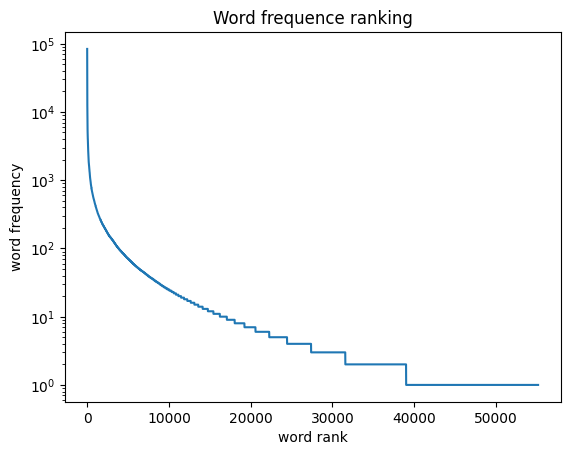

In [11]:
plt.plot([x for _,x in global_frequency_list.most_common()])
plt.xlabel("word rank")
plt.ylabel("word frequency")
plt.title("Word frequence ranking")
plt.yscale("log")

In [109]:
print( global_frequency_list.most_common()[:30])

[('art', 83804), ('do', 60732), ('ust', 53636), ('na', 50643), ('się', 45886), ('lub', 45800), ('poz', 45224), ('nr', 44942), ('oraz', 33558), ('mowa', 28783), ('nie', 22988), ('przez', 20951), ('pkt', 19124), ('dnia', 17954), ('których', 17932), ('od', 16683), ('po', 13546), ('jest', 13197), ('ustawy', 13099), ('może', 12096), ('jeżeli', 12038), ('którym', 11789), ('za', 11142), ('brzmienie', 10576), ('spraw', 10021), ('otrzymuje', 9835), ('albo', 8708), ('dodaje', 8423), ('ich', 8199), ('dla', 7934)]


<h4>Morfeusz usage

In [53]:
in_morf = [(x,y) for x,y in global_frequency_list.most_common() if morf.analyse(x)[0][2][2]!='ign']
not_in_morf = [(x,y) for x,y in global_frequency_list.most_common() if morf.analyse(x)[0][2][2]=='ign']

<h4>Top 30 words not in dictionary</h4>

In [121]:
not_in_dict_top = not_in_morf[:30]
for x,y in not_in_dict_top:
    print(x)

poz
późn
str
gmo
sww
operacyjno
skw
rolno
zm
ex
ike
społeczno
techniczno
remediacji
ure
rozdz
uke
itp
kn
sanitarno
charytatywno
np
cn
pkwiu
udt
bswsg
bswp
biobójczych
organizacyjno
phs


<h4>30 random words not in dictionary</h4>

In [116]:
not_in_dict_rand = [w for w,count in not_in_morf if len(w)==5 ]
random.Random(40).shuffle(not_in_dict_rand)
not_in_dict_rand = not_in_dict_rand[:30]
for x in not_in_dict_rand:
    print(x)

soraz
szero
chuli
chemi
nakry
związ
zacią
reach
trafo
pepap
rwnie
hamex
haccp
entso
visna
guido
fiapf
dnego
znych
tlene
schro
iboga
menty
czych
ktrzy
caapi
eures
alilu
zasto
diolu


<h4>Levenshtein distance implementation</h4>

In [79]:
#Implementation by Vatsal P. on Towards Data Science
def lev_dist(a, b):
    @lru_cache(None)  
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

<h4>Levenshtein distance corrections prediction</h4>

In [122]:
def predict_corrections(to_correct,in_dictionary):
    corrections={}
    for w in to_correct:
        distance_allowed = 0
        corrections[w]=[]
        found = False
        while(not found):
            distance_allowed += 1
            for correction in in_dictionary:
                if lev_dist(w, correction) == distance_allowed:
                    found = True
                    corrections[w].append(correction) 
    return corrections
words_in_dict = [x for x,_ in in_morf]
not_in_dict_top = [x for x,y in not_in_dict_top]
predictions_top=predict_corrections(not_in_dict_top,words_in_dict)
start = time.time()
predictions_rand=predict_corrections(not_in_dict_rand,words_in_dict)
end = time.time()
print(end - start)

81.7450385093689


In [95]:
predictions_top

{'poz': ['po', 'pod', 'poza', 'roz', 'pol', 'prz', 'pop'],
 'późn': ['plan', 'pól', 'pan', 'pln', 'pół', 'pn', 'płyn', 'paź'],
 'str': ['sar', 'st', 'stu', 'sto'],
 'gmo': ['go', 'mo', 'imo', 'gm'],
 'sww': ['swe', 'swą', 'sw', 'sów'],
 'operacyjno': ['operacyjne',
  'operacyjną',
  'operacyjna',
  'operacyjny',
  'operacyjni'],
 'skw': ['kw', 'sw', 'sów'],
 'rolno': ['rolne', 'wolno', 'rolną', 'rolny', 'rolna', 'rolni'],
 'zm': ['za', 'ze', 'zł', 'im', 'mm', 'cm', 'km', 'am', 'em', 'gm'],
 'ex': ['ix', 'ej', 'xx', 'en', 'em', 'es', 'ef', 'et'],
 'ike': ['ile'],
 'społeczno': ['społeczne',
  'społeczną',
  'społeczny',
  'społeczna',
  'społeczni'],
 'techniczno': ['techniczne',
  'techniczny',
  'techniczną',
  'techniczna',
  'techniczni'],
 'remediacji': ['mediacji'],
 'ure': ['ue', 'urz'],
 'rozdz': ['rozkaz', 'rodzi', 'roz', 'rodu'],
 'uke': ['ue'],
 'itp': ['atp', 'ity'],
 'kn': ['on',
  'kg',
  'in',
  'km',
  'kw',
  'mn',
  'ku',
  'ka',
  'en',
  'kin',
  'pn',
  'ki'],
 'san

In [96]:
predictions_rand

{'soraz': ['oraz'],
 'szero': ['szefa',
  'szef',
  'swego',
  'sześć',
  'sfery',
  'czego',
  'sierot',
  'szefom',
  'sfera',
  'sferą',
  'sery',
  'szkło',
  'styro',
  'stert',
  'szeroko',
  'szereg',
  'szeroki'],
 'chuli': ['chwili',
  'czyli',
  'uchyli',
  'celi',
  'chęci',
  'holi',
  'coli',
  'uli',
  'hali'],
 'chemi': ['chemii', 'chemia'],
 'nakry': ['nakryć'],
 'związ': ['związku', 'związek', 'związki', 'wiz', 'świąt', 'zwiad', 'zwie'],
 'zacią': ['zaciąg'],
 'reach': ['ramach',
  'celach',
  'rentach',
  'cenach',
  'cech',
  'grach',
  'ratach',
  'ruch',
  'radach',
  'lekach',
  'reali',
  'rowach',
  'blach',
  'pesach',
  'rzekach',
  'ach',
  'ulach',
  'kach'],
 'trafo': ['prawo',
  'traci',
  'tracą',
  'trasy',
  'trasa',
  'trwało',
  'trasę',
  'traw',
  'tras',
  'trasą',
  'traki',
  'trafne',
  'brało',
  'trawę',
  'trans'],
 'pepap': ['etap', 'peda'],
 'rwnie': ['równie', 'renie'],
 'hamex': ['samej', 'same', 'haseł', 'kamer'],
 'haccp': ['marca',
  '

<h4>Loading SGJP into elasticsearch</h4>

In [101]:
client = Elasticsearch("https://localhost:9200",
                    #verify_certs=False,
                       ca_certs='../../elasticsearch-8.4.3//config/certs/http_ca.crt',
                       basic_auth=("elastic", 'zu02AJZclkOQ692G1dtr'))
client.info()
client.indices.create(index="sgjp")
dict_words=[]

with open('../sgjp-20221023.tab', encoding='utf-8') as f:
    for line in f:
        if len(line.split()) != 4:
            continue
        else:
            dict_words.append(line.split()[0])
bulk_query = [{'_index': "sgjp", 'word': word} for word in dict_words]
helpers.bulk(client, bulk_query)

(3195228, [])

<h4>Elasticsearch correction prediction</h4>

In [123]:
es_corrections={}
start = time.time()
for to_correct in not_in_dict_rand:
    es_corrections[to_correct]=[]
    result = client.search(index='sgjp', body={"query": {"fuzzy": {"word": {"value": to_correct, "fuzziness": 2}}}})
    es_corrections[to_correct]=[correction['_source']['word'] for correction in result['hits']['hits']]
end = time.time()
print(end - start)
print(es_corrections)

C:\Users\KPR\AppData\Local\Temp\ipykernel_23332\729774045.py:5: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  result = client.search(index='sgjp', body={"query": {"fuzzy": {"word": {"value": to_correct, "fuzziness": 2}}}})


0.29030919075012207
{'soraz': ['Doraz', 'oraz', 'Borak', 'Borak', 'Boral', 'Boral', 'Boras', 'Boras', 'Borcz', 'Borcz'], 'szero': ['Spero', 'Spero', 'Stero', 'Stero', 'Szaro', 'Szaro', 'Szaro', 'Szaro', 'Szaro', 'Szego'], 'chuli': ['Chyli', 'Chyli', 'Chyli', 'Chyli', 'Huli', 'Huli', 'Huli', 'Huli', 'Anuli', 'Anuli'], 'chemi': ['chami', 'chemia', 'chemie', 'chemii', 'chemii', 'chemio', 'chemią', 'chemię', 'chemik', 'Cemki'], 'nakry': ['Nakły', 'Nakory', 'Nakły', 'Nawry', 'Nawry', 'Nawry', 'Nawry', 'Sakry', 'Sakry', 'Sakry'], 'związ': ['Wiąz', 'Wiąz', 'wiąz', 'Owidz', 'Wiąza', 'Wiązy', 'Zawidz', 'Zawidz', 'Zawisz', 'Zawisz'], 'zacią': ['Bacią', 'Bacią', 'Gacią', 'Gacią', 'Gacią', 'Hacią', 'Hacią', 'Pacią', 'Pacią', 'Zachą'], 'reach': ['Leach', 'Leach', 'Recach', 'Recach', 'Recach', 'Redach', 'Redach', 'Redach', 'Redach', 'Regach'], 'trafo': ['Tralo', 'Tralo', 'Trawo', 'Trawo', 'Trało', 'Trało', 'trafom', 'trafu', 'trafy', 'tramo'], 'pepap': ['Pepaś', 'Pepaś', 'Cepak', 'Cepak', 'Lepak', '

<h4>Distribution of words in the corpus</h4>
<p>We see that some words are clearly more common in the corpus than others with a significant drop in usage as we move along the ranks. There is a tenfold decrease in usage between the most common word in corpus and the 30th most common one. Other than that less than half of words appear more that ten times. Those discrepancies can steam from two factors, one being the topic of the texts (since high usage of words like ustawa, spraw etc) and the other being the fact that some words are simply common in usage such as: się, na, lub.</p>

<h4>Misspellings versus unknowns</h4>
<p>Looking at he the random words not in the dictionary with five occurrences we can clearly see that while some words are easily identifiable as misspellings (soraz
-oraz, dnego-danego, ktrzy-którzy), some simply don’t exist in the dictionary used (visna - prawdopodobnie nazwa miasta, hamex - prawdopodobnie nazwa własna, reach - prawdopodobnie słowo z języka angielskiego) dodatkowo niektóre słowa ciężko przypisać do którejś z tych dwóch grup nie znając kontekstu ich użycia (chuli, pepap, diolu). Additionally some words seem to be split by tokenization (schro, zasto) and thus not found in the dictionary.</p>
<p>When looking at the most common words not found in the dictionary we see that much less of them look like misspellings compared to the randomly chosen ones. Most words from this list look like abbreviations (zm, ike, ex, gmo, skw,str) others look like unknown in the dictionary declinations (rolno, społeczno, techniczno, sanitarno)</p>

<h4>Performance of methods</h4>
<p>
In terms of performance it is hard to compare the Elasticsearch method and the Levenshtein method in terms of
the quality of corrections they provide. As such the main metric of comparison chosen was time of execution.</p>
<p>Time of execution for Levenshtein: 81.7450385093689s</p>
<p>Time of execution for Elasticsearch: 0.2903091907501s</p>
Elasticsearch method clearly outperforms Levenshtein in terms of execution time.



<h4>Correction result comparison and the validity of results</h4>
<p>The results returned by both methods seem to be significantly different. Elasticsearch returned more possible corrections for most words given (as it is based on the whole SGJP dictionary while the Levenshtein approach used only words from the dictionary that have appeared in the text corpus) and in much shorter time. While the Levenshtein usually returned less results per word, the corrections returned seem to be of higher quality than the Elasticsearch ones. For example for word “soraz” Levensthein returned  only one correction “oraz” while Elasticsearch returned a whole array of corrections: ['Doraz', 'oraz', 'Borak', 'Borak', 'Boral', 'Boral', 'Boras', 'Boras', 'Borcz', 'Borcz'] most of those seem to be proper names and thus not applicable in most cases. For the Levenshtein method most words searched seem to get at least one fitting correction; validity of those corrections is corroborated by the fact that those corrections already exist in both the dictionary given and the text corpus used. In the case of Elasticsearch the corrections returned seem to be of lesser quality. While both methods utilize the Levenshtein distance the results are vastly different due to different dictionary bases and probably due to different selection of possible corrections to be checked (while my algorithm traverses the whole dictionary given it is highly unlikely that Elasticsearch does the same).</p>